# Gun deaths/ownership per capita

I recently saw this image on a left-leaning political YouTube channel, and it seemed like it would be a fun thing to verify, since it seems to play into the anti-firearm narrative of the left, as there is an apparent correlation between gun ownership in general and gun deaths from all causes.

![chart](inspo.jpg)

I have pulled population/demographic data, gun ownership data, and gun fatality data to see if my results look similar. I will also color each dot by the winner of the presidential election of that state in the 2020 election.

Sources are as follows:
- [Gun fatalities (CDC)](https://www.cdc.gov/nchs/pressroom/sosmap/firearm_mortality/firearm.htm)
- [Population per state 2020 (US Census)](https://data.census.gov/cedsci/table?q=population%20by%20state&tid=DECENNIALPL2020.P1)
- [Gun ownership rates (World Population Review)](https://worldpopulationreview.com/state-rankings/gun-ownership-by-state)
- [2020 Presidential Election results](https://www.cookpolitical.com/2020-national-popular-vote-tracker)

So we are going to do some light analysis to see if we the above chart is roughly accurate. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
sns.set()

## Election Result Data

In [2]:
election_results = pd.read_csv("election-results.csv")
election_results.head()

,state,called,final,dem_votes,rep_votes,other_votes,dem_percent,rep_percent,other_percent,dem_this_margin,...,stateid,EV,X,Y,State_num,Center_X,Center_Y,Unnamed: 19,2016 Margin,Total 2016 Votes
0,Arizona,D,Yes,"1,672,143","1,661,686","53,497",49.4%,49.1%,1.6%,0.3%,...,AZ,11,2,2,4,205,374,NaN,-0.035456,"2,573,165"
1,Florida,R,Yes,"5,297,045","5,668,731","101,680",47.9%,51.2%,0.9%,-3.4%,...,FL,29,8,0,12,787,520,NaN,-0.011986,"9,420,039"
2,Georgia,D,Yes,"2,473,633","2,461,854","62,229",49.5%,49.3%,1.2%,0.2%,...,GA,16,7,1,13,734,419,NaN,-0.051313,"4,092,373"
3,Iowa,R,Yes,"759,061","897,672","34,138",44.9%,53.1%,2.0%,-8.2%,...,IA,6,5,4,19,536,223,NaN,-0.094068,"1,566,031"
4,Maine 2nd District,R,Yes,"168,696","196,692","10,961",44.8%,52.3%,2.9%,-7.4%,...,ME2,1,12,8,102,919,92,NaN,-0.102882,"353,416"


We only need which party won, so while this data is interesting, we will drop the vast majority of it.

In [3]:
cols = ["state", "stateid", "called"]
election_results = election_results[cols]

# rename stateid column for ease of joining
election_results.rename(columns = {"stateid": "state_id"}, inplace=True)
election_results.head()

,state,state_id,called
0,Arizona,AZ,D
1,Florida,FL,R
2,Georgia,GA,D
3,Iowa,IA,R
4,Maine 2nd District,ME2,R


Maine and Nebraska split their electors, so we will color them gray in the final plot. That in mind, we will remove their split electors for ease of use with the rest of the data, which is totalled by state. Additionally, since we don't have DC in our gun ownership data, we will have to drop it from here as well.

In [4]:
is_split = election_results["state_id"].str.len() > 2
is_dc = election_results["state_id"] == "DC"
election_results = election_results[~is_split & ~is_dc]
election_results.shape

(50, 3)

## Simplifying population data

In [5]:
population = pd.read_csv("state-population.csv")
population.head()

,Label (Grouping),Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Puerto Rico
0,Total:,"5,024,279","733,391","7,151,502","3,011,524","39,538,223","5,773,714","3,605,944","989,948","689,545",...,"6,910,840","29,145,505","3,271,616","643,077","8,631,393","7,705,281","1,793,716","5,893,718","576,851","3,285,874"
1,Population of one race:,"4,767,326","643,867","6,154,696","2,797,949","33,777,988","5,066,044","3,273,040","913,430","633,468",...,"6,497,942","24,011,767","2,992,603","606,051","7,925,686","6,868,622","1,708,772","5,534,184","533,378","1,650,083"
2,White alone,"3,220,452","435,392","4,322,337","2,114,512","16,296,122","4,082,927","2,395,128","597,763","273,194",...,"4,990,938","14,609,365","2,573,413","577,751","5,208,856","5,130,920","1,610,749","4,737,545","488,374","560,592"
3,Black or African American alone,"1,296,162","21,898","339,150","453,783","2,237,044","234,828","388,675","218,899","285,810",...,"1,092,948","3,552,997","40,058","9,034","1,607,581","307,565","65,813","376,256","5,232","228,711"
4,American Indian and Alaska Native alone,"33,625","111,575","319,512","27,177","631,016","74,129","16,051","5,148","3,193",...,"28,044","278,948","41,644","2,289","40,007","121,468","3,706","60,428","13,898","17,870"


In [6]:
population = population.iloc[0].reset_index()
population.columns = ["state", "population"]
population = population[1:]
population.sample(5)

,state,population
43,Tennessee,"6,910,840"
32,New Mexico,"2,117,522"
2,Alaska,"733,391"
19,Louisiana,"4,657,757"
25,Mississippi,"2,961,279"


The population column contains commas, which mean's it's currently a column of strings. If we are going to plot it, it needs to be integers, so we can fix that.

In [7]:
population["population"] = population["population"].str.replace(",", "").astype(np.int64)
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 1 to 52
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   state       52 non-null     object
 1   population  52 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 964.0+ bytes


In [8]:
population.shape

(52, 2)

Too many rows means DC and Puerto Rico are still here. Since they aren't in our ownership data, we will have to drop them.

In [9]:
to_drop = population["state"].isin(["District of Columbia", "Puerto Rico"])
population = population[~to_drop]
population.shape

(50, 2)

## Gun Ownership Data

In [10]:
gun_ownership = pd.read_csv("gun-ownership.csv")

# rename columns for ease of joining
gun_ownership.rename(columns = {"gunOwnership": "gun_own_rate"}, inplace=True)
gun_ownership.columns = gun_ownership.columns.str.lower()
gun_ownership.head()

,state,gun_own_rate,totalguns
0,Montana,0.663,22133
1,Wyoming,0.662,132806
2,Alaska,0.645,15824
3,Idaho,0.601,49566
4,West Virginia,0.585,35264


We won't need the total number of guns registered per state for this analysis, so we can drop that. Note that this is the dataset that does not contain DC, hence the shape starting at 50 rows.

In [11]:
gun_ownership.drop("totalguns", axis=1, inplace=True)
gun_ownership.shape

(50, 2)

## Gun Fatalities Data

In [12]:
gun_death = pd.read_csv("gun-deaths.csv")
gun_death.columns = gun_death.columns.str.lower()

# rename state column for ease of joining
gun_death.rename(columns = {"state": "state_id"}, inplace = True)
gun_death.head()

,year,state_id,rate,deaths,url
0,2020,AL,23.6,1141,/nchs/pressroom/states/alabama/al.htm
1,2020,AK,23.5,175,/nchs/pressroom/states/alaska/ak.htm
2,2020,AZ,16.7,1265,/nchs/pressroom/states/arizona/az.htm
3,2020,AR,22.6,673,/nchs/pressroom/states/arkansas/ar.htm
4,2020,CA,8.5,3449,/nchs/pressroom/states/california/ca.htm


In [13]:
gun_death.shape

(400, 5)

Clearly there are far too many rows here. I assume that this is because of there being multiple years, so we can find that out and clean it up. Also, we won't need the URL, RATE, or YEAR columns once we figure out why our data is so large.

In [14]:
gun_death["year"].unique()

array([2020, 2019, 2018, 2017, 2016, 2015, 2014, 2005])

As expected, too many years. We are working with 2020 population data, so we will keep 2020 here as well, and then drop those excess columns.

In [15]:
is_2020 = gun_death["year"] == 2020
gun_death = gun_death[is_2020]
gun_death.drop(["url", "rate", "year"], axis=1, inplace=True)
gun_death.shape

(50, 2)

In [16]:
gun_death.columns = ["state_id", "gun_deaths"]
gun_death.head()

,state_id,gun_deaths
0,AL,1141
1,AK,175
2,AZ,1265
3,AR,673
4,CA,3449


## Join all data into one dataframe

In [17]:
# merge population, gun ownwership, and election result data using "state" header
combined = election_results.merge(population, how="inner", on="state")
combined = combined.merge(gun_ownership, how="inner", on="state")
combined.sample(5)

,state,state_id,called,population,gun_own_rate
37,North Dakota,ND,R,779094,0.551
0,Arizona,AZ,D,7151502,0.463
20,Hawaii,HI,D,1455271,0.149
26,Louisiana,LA,R,4657757,0.531
7,New Hampshire,NH,D,1377529,0.411


In [18]:
# annotate states with split electors
combined.loc[combined["state_id"].isin(["ME","NE"]), "called"] = "S"

# merge gun death data with the rest using "state_id" header
combined = combined.merge(gun_death, how="inner", on="state_id")

# rename "called" column to be more descriptive
combined.rename(columns = {"called": "elec_winner"}, inplace=True)
combined

,state,state_id,elec_winner,population,gun_own_rate,gun_deaths
0,Arizona,AZ,D,7151502,0.463,1265
1,Florida,FL,R,21538187,0.353,3041
2,Georgia,GA,D,10711908,0.492,1897
3,Iowa,IA,R,3190369,0.436,351
4,Michigan,MI,D,10077331,0.402,1454
5,Minnesota,MN,D,5706494,0.428,513
6,Nevada,NV,D,3104614,0.473,547
7,New Hampshire,NH,D,1377529,0.411,128
8,North Carolina,NC,R,10439388,0.458,1699
9,Ohio,OH,R,11799448,0.400,1764


Calculating gun fatalities per 100,000 residents per the chart in question:

In [19]:
combined["deaths_per_capita"] = combined["gun_deaths"] / (combined["population"] / 100000)
combined.sample(5)

,state,state_id,elec_winner,population,gun_own_rate,gun_deaths,deaths_per_capita
31,Missouri,MO,R,6154913,0.488,1426,23.168483
34,New Jersey,NJ,D,9288994,0.147,443,4.769085
27,Maine,ME,S,1362359,0.468,153,11.230520
15,Arkansas,AR,R,3011524,0.572,673,22.347489
12,Wisconsin,WI,D,5893718,0.453,717,12.165496


## Plot ownership/fatality correlation

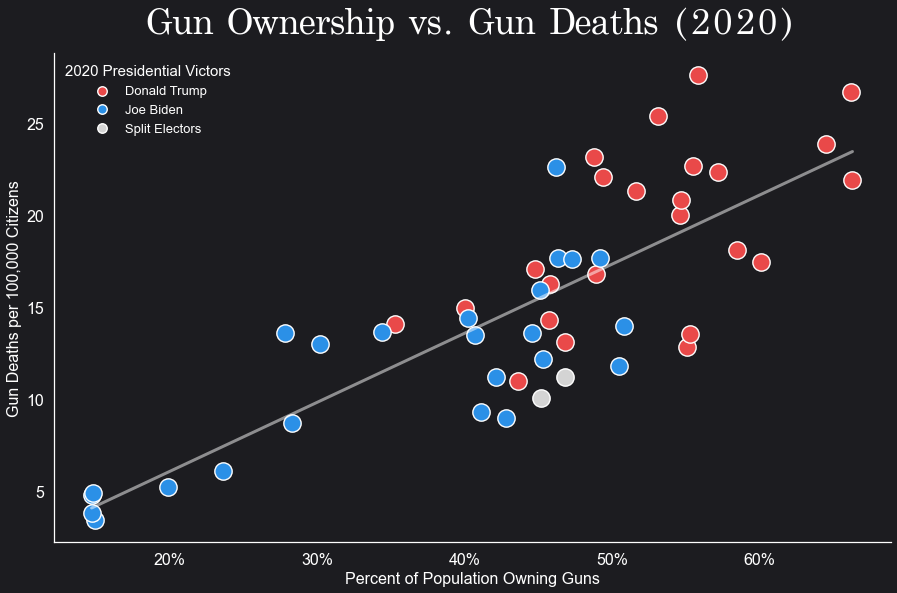

In [21]:
REP = "#e94949"
DEM = "#2b90e7"
SPLIT = "#d4d4d4"
fig = plt.figure(figsize=(15,9))

sns.set(rc={
    "axes.facecolor": "#1c1c20",
    "figure.facecolor": "#1c1c20"
})

# calculate line of best fit
x = combined["gun_own_rate"]
y = combined["deaths_per_capita"]
m,b = np.polyfit(x,y,1)

# plot line of best fit
y = (m * x) + b
line = sns.lineplot(x=x ,y=y, linewidth=3, color="white", alpha=0.5)

# plot scatter
ax_rep = sns.scatterplot(
    x = "gun_own_rate",
    y = "deaths_per_capita",
    data = combined[combined["elec_winner"] == "R"],
    s = 300,
    color = REP,
    alpha = 1,
    label = "Donald Trump"
)

ax_dem = sns.scatterplot(
    x = "gun_own_rate",
    y = "deaths_per_capita",
    data = combined[combined["elec_winner"] == "D"],
    s = 300,
    color = DEM,
    alpha = 1,
    label = "Joe Biden"
)

ax_split = sns.scatterplot(
    x = "gun_own_rate",
    y = "deaths_per_capita",
    data = combined[combined["elec_winner"] == "S"],
    s = 300,
    color = SPLIT,
    alpha = 1,
    label = "Split Electors"
)

plt.title(
    "Gun Ownership vs. Gun Deaths (2020)", 
    fontsize = 35, 
    fontweight = "bold", 
    pad = 20, 
    color = "white",
    fontname = "AppleMyungjo"
)

# customize legend
legend = plt.legend(
    title = "2020 Presidential Victors", 
    fontsize=13,
    labelcolor = "white",
    frameon = False
)

# change size of marker in the legend
for handle in legend.legendHandles:
    handle.set_sizes([90])
    
plt.setp(legend.get_title(), color="white", fontsize=15)

# customize axes
ax_rep.grid(False)
ax_rep.spines[["top","right"]].set_visible(False)
xticks = ax_rep.get_xticks().tolist()
ax_rep.xaxis.set_major_locator(mtick.FixedLocator(xticks))
ax_rep.set_xticklabels(["", "20%", "30%", "40%", "50%", "60%", ""])

plt.xticks(color="white", fontsize=16)
plt.yticks(color="white", fontsize=16)
plt.ylabel("Gun Deaths per 100,000 Citizens", color="white", fontsize=16)
plt.xlabel("Percent of Population Owning Guns", color="white", fontsize=16)

plt.savefig("final.png", bbox_inches="tight")

plt.show()

## Conclusion

While our data looks different than the original, there does still seem to be a positive correlation between gun ownership rates and gun fatality rates. This does not necessarily prove causation, and many on the right argue that we should only count gun murders, not all gun fatalities. However, the data presented in the video in question was likely sound. 

The distinction between party affiliation is interesting as well, with Republican states clearly among the top in both gun ownership and fatality. The opposite extreme is held exclusively by Democratic-leaning states, while many from both parties lie towards the middle.

Overall, this was an interesting and fun project and I think the insights are valuable. My choice to neglect individual state labels came down to a matter of time, but if anyone wants to clone this notebook and label them, I would happily pull it into [the GitHub repository where this project is kept](https://github.com/MitchellHarrison/data-viz-for-social-media).

Thanks for reading! Feel free to stop by [my Twitch stream](https://twitch.tv/mitchsworkshop) where we will build more policy-focussed data visualization soon. 